In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import torch
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from evanqp import MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from utils import dlqr

In [3]:
class DoubleIntegrator(MPCProblem):
    def __init__(self, N=10, soft=False):
        self.N = N
        self.soft = soft

        n = 2
        m = 1

        # simple double integrator
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])

        self.Q = np.diag([1, 1])
        self.R = np.array([[0.1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)

        self.x0 = cp.Parameter(n, name='x0')
        self.x = cp.Variable((N + 1, n), name='x')
        self.u0 = cp.Variable(m, name='u0')
        self.u = cp.Variable((N, m), name='u')
        if soft:
            self.s = cp.Variable(name='s')

        objective = cp.quad_form(self.x[N, :], self.P)
        constraints = [self.x0 == self.x[0, :], self.u0 == self.u[0, :]]
        if soft:
            objective += 1e4 * cp.norm1(self.s) + 1e4 * cp.norm2(self.s)
            constraints += [self.s >= 0]

        for i in range(N):
            objective += cp.quad_form(self.x[i, :], self.Q) + cp.quad_form(self.u[i, :], self.R)
            constraints += [self.x[i + 1, :] == self.A @ self.x[i, :] + self.B @ self.u[i, :]]
            constraints += [-1 <= self.u[i, :], self.u[i, :] <= 1]
            if soft:
                constraints += [np.array([-10, -10]) <= self.x[i, :] + self.s,
                                self.x[i, :] <= np.array([10, 10]) + self.s]
            else:
                constraints += [np.array([-10, -10]) <= self.x[i, :],
                                self.x[i, :] <= np.array([10, 10])]
                
        F = np.array([[0.350890122368220,0.936416639121933],
                      [-0.350890122368220,-0.936416639121933],
                      [-0.767238634097463,-0.641361737515000],
                      [0.767238634097463,0.641361737515000]])
        f = np.array([0.605849050537715,0.605849050537715,2.427883893963656,2.427883893963656])
        constraints += [F @ self.x[N, :] <= f]

        self.objective = cp.Minimize(objective)
        self._problem = cp.Problem(self.objective, constraints)

    def problem(self):
        return self._problem

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        self._problem.solve(solver=cp.GUROBI)

        solution = {self.u0: self.u0.value,
                    self.u: self.u.value,
                    self.x: self.x.value,
                    self.objective: self.objective.value}
        return solution

    def reduced_objective(self):
        objective = cp.quad_form(self.x[self.N, :], self.P)
        if self.soft:
            objective += 1e4 * cp.norm1(self.s) + 1e4 * cp.norm2(self.s)
        for i in range(1, self.N):
            objective += cp.quad_form(self.x[i, :], self.Q) + cp.quad_form(self.u[i, :], self.R)
        return cp.Minimize(objective)

In [4]:
mpc_controller = DoubleIntegrator()

In [6]:
x1 = np.linspace(-10, 10, 250)
x2 = np.linspace(-6, 6, 250)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        z_opt[i, j] = u0 if u0 is not None else None

100%|██████████| 250/250 [06:35<00:00,  1.58s/it]


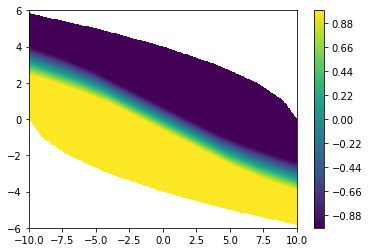

In [7]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
fig.colorbar(cs)
plt.show()

In [8]:
parameter_set = Polytope(np.array([[1, 0], [-1, 0], [0, 1], [0, -1]]), np.array([10, 10, 10, 10]))

In [9]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(10000, seed=0)

100%|██████████| 10000/10000 [02:27<00:00, 67.65it/s]


In [10]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples.pt')
torch.save(variable_samples, 'variable_samples.pt')

In [11]:
class DoubleIntegratorDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [12]:
dataset = DoubleIntegratorDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [13]:
!python3 train.py --train-set-ratio {train_set_ratio} --seed {seed}

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.953956
Train Epoch: 1 [1280/8000 (16%)]	Loss: 0.706792
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.270024
Train Epoch: 1 [3840/8000 (48%)]	Loss: 0.152905
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.072452
Train Epoch: 1 [6400/8000 (79%)]	Loss: 0.026421
Train Epoch: 1 [7680/8000 (95%)]	Loss: 0.015031

Test set: Average loss: 0.008460)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.008736
Train Epoch: 2 [1280/8000 (16%)]	Loss: 0.006925
Train Epoch: 2 [2560/8000 (32%)]	Loss: 0.004418
Train Epoch: 2 [3840/8000 (48%)]	Loss: 0.001819
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.002377
Train Epoch: 2 [6400/8000 (79%)]	Loss: 0.002205
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.001396

Test set: Average loss: 0.001106)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.000774
Train Epoch: 3 [1280/8000 (16%)]	Loss: 0.001677
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.000886
Train Epoch: 3 [3840/8000 (48%)]	Loss: 0.001049
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.001239
Train Epoch: 3 [6400/8000 (7

In [14]:
parameter_samples = torch.load('parameter_samples.pt')
variable_samples  = torch.load('variable_samples.pt')

In [15]:
saved_model = torch.load('double_integrator_ffnn.pt')

depth = saved_model['depth']
hidden_size = saved_model['hidden_size']

net = FFNN([hidden_size for _ in range(depth)], input_size=saved_model['input_size'], output_size=saved_model['output_size'])
net.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

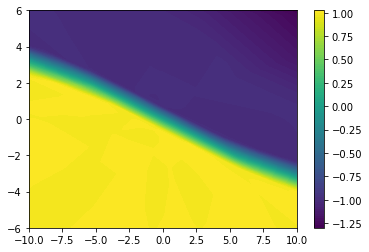

In [16]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
fig.colorbar(cs)
plt.show()

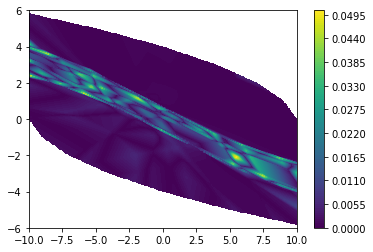

In [17]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
fig.colorbar(cs)
plt.show()

In [18]:
verifier = Verifier(mpc_controller, net, parameter_set)

In [20]:
ref_bounds, approx_bounds = verifier.compute_bounds()

print('Reference Problem Bounds for Variables:')
print(f'lower bound: {ref_bounds["lb"]}')
print(f'upper bound: {ref_bounds["ub"]}')
print()
print('Approximate Problem Bounds for Variables:')
print(f'lower bound: {approx_bounds["lb"]}')
print(f'upper bound: {approx_bounds["ub"]}')

Reference Problem Bounds for Variables:
lower bound: [-1.]
upper bound: [1.]

Approximate Problem Bounds for Variables:
lower bound: [-19.54451795]
upper bound: [18.35782171]


In [21]:
bound, parameters = verifier.find_max_abs_diff()

Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 567 rows, 484 columns and 2439 nonzeros
Model fingerprint: 0x509f2912
Model has 278 general constraints
Variable types: 345 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 6e+01]
  RHS range        [2e-02, 6e+01]
Presolve removed 141 rows and 175 columns
Presolve time: 0.03s
Presolved: 426 rows, 309 columns, 2458 nonzeros
Presolved model has 36 SOS constraint(s)
Variable types: 199 continuous, 110 integer (110 binary)

Root relaxation: objective 1.246605e+01, 498 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

In [22]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound} at {parameters}')
u0_mpc = mpc_controller.solve(np.array(parameters))[mpc_controller.u0][0]
u0_net = net(torch.from_numpy(np.array(parameters)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 0.05076619122363446 at [-10.0, 2.4201524493632887]
Double Checking by calulcaing error at this position: 0.05070798146453992


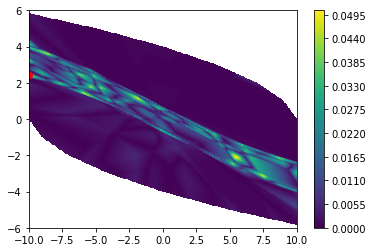

In [23]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
ax.plot(parameters[0], parameters[1], 'ro')
fig.colorbar(cs)
plt.show()

In [24]:
bound, parameters = verifier.verify_stability()

Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 683 rows, 543 columns and 2627 nonzeros
Model fingerprint: 0x9572500d
Model has 63 quadratic objective terms
Model has 276 general constraints
Variable types: 404 continuous, 139 integer (139 binary)
Coefficient statistics:
  Matrix range     [3e-04, 6e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 7e+00]
  Bounds range     [1e-01, 6e+01]
  RHS range        [2e-02, 6e+01]
Presolve removed 231 rows and 207 columns
Presolve time: 0.04s
Presolved: 486 rows, 400 columns, 2490 nonzeros
Presolved model has 36 SOS constraint(s)
Presolved model has 32 quadratic constraint(s)
Presolved model has 31 bil

In [25]:
print(f'Stability bound: {bound} at {parameters}, should be >=0 for stability')

Stability bound: -1.3097107306619577e-05 at [0.0012693374952554848, 0.0013813234036934574], should be >=0 for stability
